In [90]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from process_raw_data import *
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1


In [4]:
pdx_agg_matrixPath = '/wynton/scratch/bp205/raw/BC_MULTIseq_JW/crPDX1_PDX3_aggregate/filtered_feature_bc_matrix/'
pdx_cellBC = '/wynton/scratch/bp205/raw/BC_MULTIseq_JW/PDX_meta.txt'
pd_metadata = '/wynton/scratch/bp205/raw/BC_MULTIseq_JW/MULTIseq_aggr_PDX1_PDX3_metadata.csv'

outfilePath = '/wynton/scratch/bp205/processed/PDX_adata.h5ad'
outfilePath_R = '/wynton/scratch/bp205/processed/PDX_adata_R/'
outfilePath_csv = '/wynton/scratch/bp205/processed/PDX_adata_R/PDX_adata.csv'

outfilePathNorm = '/wynton/scratch/bp205/processed/PDX_normalized_adata.h5ad'
outfilePathNorm_R = '/wynton/scratch/bp205/processed/PDX_normalized_adata_R/'
outfilePathNorm_csv = '/wynton/scratch/bp205/processed/PDX_normalized_adata_R/PDX_normalized_adata.csv'

In [5]:
cellBCmap = pd.read_csv(pdx_cellBC,sep='\t',header=None,skiprows=1).rename(columns={0: "cellBC", 1: "SampleType"})
barID_replace_dict = {'Bar{}'.format(i):'Sample{}'.format(i+11) for i in range(1,16)}
cellBCmap.SampleType.replace(barID_replace_dict,inplace=True)
cellBCmap['pdx_id']=cellBCmap.cellBC.str.extract('([0-9]+)').astype(int)
cellBCmap['pdx'] = np.where(cellBCmap['pdx_id']<5, 'PDX1', 'PDX3')

In [6]:
cellMetadata = pd.read_csv(pd_metadata).loc[:,('Sample','Tissue','Tumor')].rename(columns={'Sample':'SampleType'})

In [7]:
pdx_agg = read_matrix(pdx_agg_matrixPath)

... reading from cache file cache/wynton-scratch-bp205-raw-BC_MULTIseq_JW-crPDX1_PDX3_aggregate-filtered_feature_bc_matrix-matrix.h5ad


In [189]:
## Merge the annotated data 
adata=pdx_agg.copy()
adata.obs = adata.obs.merge(cellBCmap,how='left',left_index=True,right_on='cellBC').merge(cellMetadata,how='left',left_on='SampleType',right_on='SampleType').set_index('cellBC')


In [190]:
## Load barnyard calculations
adata.var['organism'] = np.where(adata.var_names.str.contains('mm10'),'mm10','hg19')
adata.obs['mm10counts'] = adata[:,adata.var.organism=='mm10'].X.sum(axis=1)
adata.obs['mm10countslog'] = np.log10(adata.obs['mm10counts']+1)
adata.obs['hg19counts'] = adata[:,adata.var.organism=='hg19'].X.sum(axis=1)
adata.obs['hg19countslog'] = np.log10(adata.obs['hg19counts']+1)

adata.obs['mm10detected']=(adata[:,adata.var.organism=='mm10'].X>=5).sum(axis=1)
adata.obs['mm10detectedlog']= np.log10(adata.obs['mm10detected']+1)

adata.obs['hg19detected']=(adata[:,adata.var.organism=='hg19'].X>5).sum(axis=1)
adata.obs['hg19detectedlog']= np.log10(adata.obs['hg19detected']+1)

adata.obs['hg19detected_div_mm10detected'] = (adata.obs['hg19detected']+1)/(adata.obs['mm10detected']+1)
adata.obs['hg19detected_div_mm10detectedlog'] = np.log10(adata.obs['hg19detected_div_mm10detected'])
adata.obs['hg19detected_div_mm10detectedlogthresh'] = np.where(adata.obs['hg19detected_div_mm10detectedlog']>1,
                                                               adata.obs['hg19detected_div_mm10detectedlog'],0)

adata.obs['goodorbad'] = np.where(adata.obs.SampleType.isin(['Doublet','Negative']),'doublet','non-doublet')

In [191]:
adata.obs.head()

SampleType  pdx_id   pdx Tissue Tumor  mm10counts  \
cellBC                                                                 
AAACCTGAGACTAGGC-1    Sample8     1.0  PDX1   lung   BC3      3104.0   
AAACCTGAGCCACTAT-1    Sample4     1.0  PDX1  tumor   BC4        36.0   
AAACCTGAGGGTCTCC-1    Doublet     1.0  PDX1    NaN   NaN      6894.0   
AAACCTGCAATCACAC-1    Sample5     1.0  PDX1  tumor   BC5        27.0   
AAACCTGCACAAGTAA-1    Sample4     1.0  PDX1  tumor   BC4        31.0   

                    mm10countslog  hg19counts  hg19countslog  mm10detected  \
cellBC                                                                       
AAACCTGAGACTAGGC-1       3.492062        57.0       1.763428           140   
AAACCTGAGCCACTAT-1       1.568202      3258.0       3.513084             0   
AAACCTGAGGGTCTCC-1       3.838534       108.0       2.037426           259   
AAACCTGCAATCACAC-1       1.447158       506.0       2.705008             0   
AAACCTGCACAAGTAA-1       1.505150      2002.0       3.301681             0   

                    mm10detectedlog  hg19detected  hg19detectedlog  \
cellBC                                                               
AAACCTGAGACTAGGC-1         2.149219             0         0.000000   
AAACCTGAGCCACTAT-1         0.000000            52         1.724276   
AAACCTGAGGGTCTCC-1         2.414973             0         0.000000   
AAACCTGCAATCACAC-1         0.000000            10         1.041393   
AAACCTGCACAAGTAA-1         0.000000            26         1.431364   

                    hg19detected_div_mm10detected  \
cellBC                                              
AAACCTGAGACTAGGC-1                       0.007092   
AAACCTGAGCCACTAT-1                      53.000000   
AAACCTGAGGGTCTCC-1                       0.003846   
AAACCTGCAATCACAC-1                      11.000000   
AAACCTGCACAAGTAA-1                      27.000000   

                    hg19detected_div_mm10detectedlog  \
cellBC                                                 
AAACCTGAGACTAGGC-1                         -2.149219   
AAACCTGAGCCACTAT-1                          1.724276   
AAACCTGAGGGTCTCC-1                         -2.414973   
AAACCTGCAATCACAC-1                          1.041393   
AAACCTGCACAAGTAA-1                          1.431364   

                    hg19detected_div_mm10detectedlogthresh    goodorbad  
cellBC                                                                   
AAACCTGAGACTAGGC-1                                0.000000  non-doublet  
AAACCTGAGCCACTAT-1                                1.724276  non-doublet  
AAACCTGAGGGTCTCC-1                                0.000000      doublet  
AAACCTGCAATCACAC-1                                1.041393  non-doublet  
AAACCTGCACAAGTAA-1                                1.431364  non-doublet

In [192]:
nan_doublet_filter = adata.obs.SampleType.isin(['Doublet','nan','Negative',np.nan])
adata_filt = adata[~nan_doublet_filter,:].copy()

In [193]:
# #sc.pl.scatter(adata,x='mm10counts',y='hg19counts',color='goodorbad')
# #sc.pl.scatter(adata,x='mm10detected',y='hg19detected',color='goodorbad')
# sc.pl.scatter(adata,x='mm10countslog',y='hg19countslog',color='Tissue')
# sc.pl.scatter(adata,x='mm10detectedlog',y='hg19detectedlog',color='Tissue')

In [194]:
# plt.figure(figsize=(20,30))
# g = sns.FacetGrid(adata.obs,row='Tumor',col='Tissue')
# g.map(plt.scatter,'mm10countslog','hg19countslog',s=0.2)
# plt.savefig(fname='/wynton/scratch/bp205/raw/BC_MULTIseq_JW/pdx_vis.png')

In [195]:
# plt.figure(figsize=(20,30))
# g = sns.FacetGrid(adata.obs,row='Tumor',col='Tissue')
# g.map(plt.scatter,'mm10detectedlog','hg19detectedlog',s=0.2)
# plt.savefig(fname='/wynton/scratch/bp205/raw/BC_MULTIseq_JW/pdx_detected_vis.png')

In [196]:
# # plt.figure(figsize=(20,30))
# # g = sns.FacetGrid(adata_filt.obs,row='Tumor',col='Tissue')
# # g.map(plt.scatter,'mm10countslog','hg19countslog',s=0.2)
# # plt.savefig(fname='/wynton/scratch/bp205/raw/BC_MULTIseq_JW/pdx_filt_vis.png')
# plt.figure(figsize=(20,30))
# g = sns.FacetGrid(adata_filt.obs,row='Tumor',col='Tissue')
# g.map(plt.scatter,'mm10detectedlog','hg19detectedlog',s=0.2)
# plt.savefig(fname='/wynton/scratch/bp205/raw/BC_MULTIseq_JW/pdx_filt_detected_vis.png')

## Filter out mouse cells by thresholding on the number of mouse genes identified with > 5 UMIs

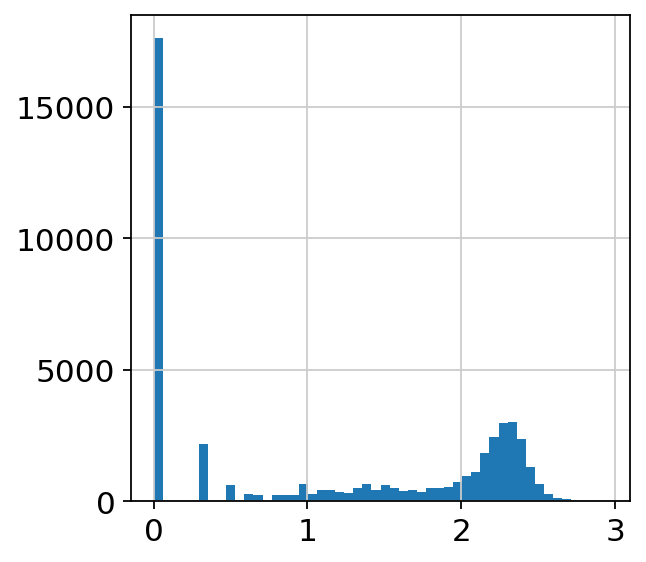

In [197]:
adata_filt.obs.mm10detectedlog.hist(bins=50)

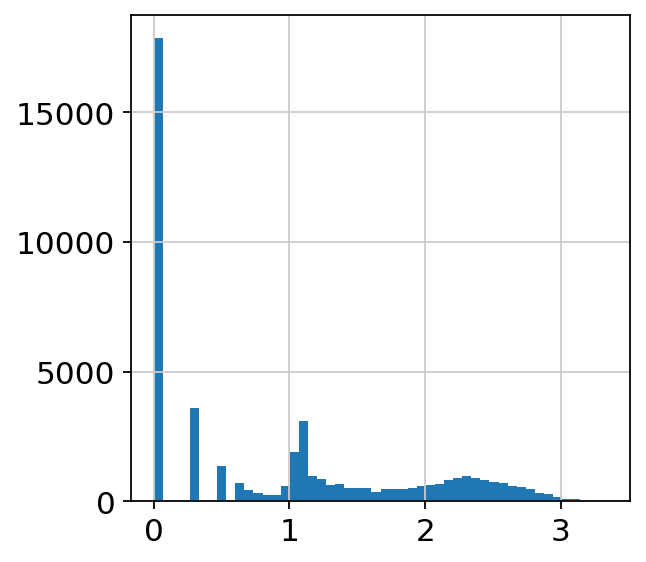

In [198]:
adata_filt.obs.hg19detectedlog.hist(bins=50)

In [199]:
adata_filt.obs['mm10detectedlogjit']= adata_filt.obs['mm10detectedlog']+np.random.uniform(-0.1,0.1,adata_filt.obs.shape[0])

adata_filt.obs['hg19detectedlogjit']= adata_filt.obs['hg19detectedlog']+np.random.uniform(-0.1,0.1,adata_filt.obs.shape[0])


... storing 'SampleType' as categorical
... storing 'pdx' as categorical
... storing 'Tissue' as categorical
... storing 'Tumor' as categorical
... storing 'goodorbad' as categorical
... storing 'feature_types' as categorical
... storing 'organism' as categorical


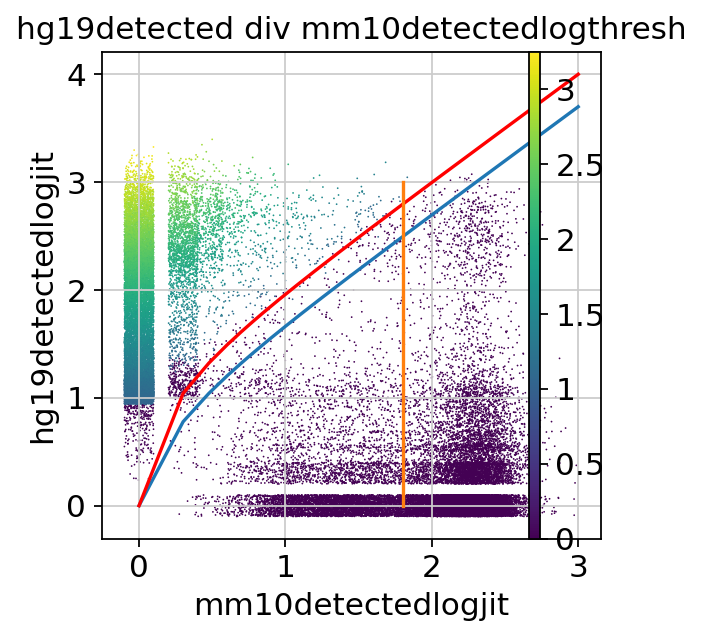

In [201]:
fig,ax1 = plt.subplots(nrows=1,ncols=1)
#ax1.set_ylim(0,3.4)
ax1.plot(np.log10(np.arange(1e3)+1),np.log10((5*np.arange(1e3))+1))
ax1.plot(np.log10(np.arange(1e3)+1),np.log10((10*np.arange(1e3))+1),'r')
ax1.plot(np.repeat(1.8,1e3),np.log10(np.arange(1e3)+1))
sc.pl.scatter(adata_filt,ax=ax1,x='mm10detectedlogjit',y='hg19detectedlogjit',
              color='hg19detected_div_mm10detectedlogthresh')
plt.savefig()

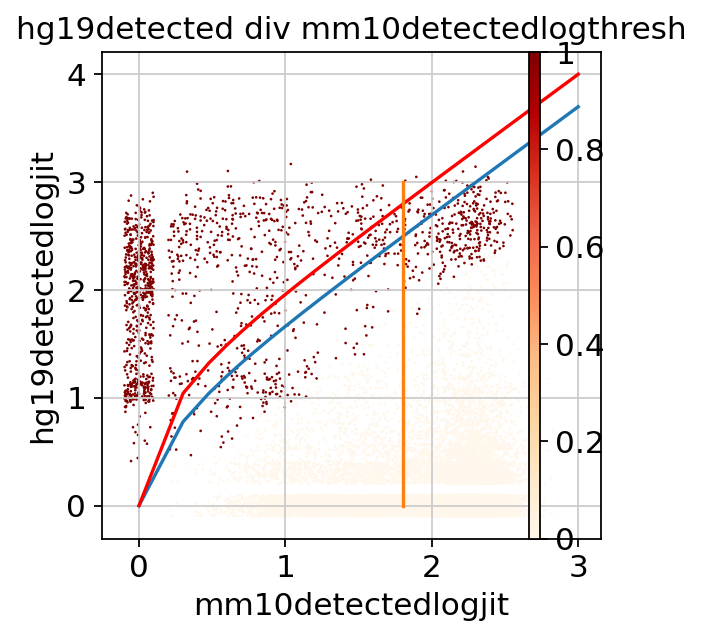

In [169]:
fig,ax1 = plt.subplots(nrows=1,ncols=1)
ax1.plot(np.log10(np.arange(1e3)+1),np.log10((5*np.arange(1e3))+1))
ax1.plot(np.log10(np.arange(1e3)+1),np.log10((10*np.arange(1e3))+1),'r')
ax1.plot(np.repeat(1.8,1e3),np.log10(np.arange(1e3)+1))
sc.pl.scatter(adata_filt[adata_filt.obs.Tissue=='lung',],ax=ax1,x='mm10detectedlogjit',
              y='hg19detectedlogjit',color='hg19detected_div_mm10detectedlogthresh',color_map='OrRd')


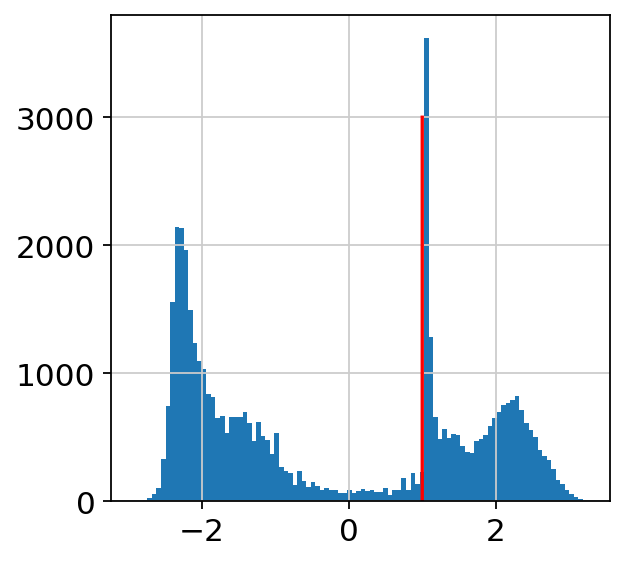

In [210]:
plt.hist(adata_filt.obs.hg19detected_div_mm10detectedlog,bins=100)
plt.plot(np.repeat(np.log10(10),3000),np.arange(3000),'r')
plt.show()

In [231]:
mouse_filter = (adata_filt.obs.hg19detected_div_mm10detected >=5) & (adata_filt.obs.mm10detectedlog<1.8)
human_genes = adata_filt.var.organism=='hg19'

In [232]:
#adata_hg19 
adata_final = adata_filt[mouse_filter,human_genes]
adata_final.var_names=adata_final.var_names.str.replace('hg19_','')

In [ ]:
#adata_final.obs[adata_final.obs.Tissue.isna()]

In [233]:
# prefix = adata_final.var_names.str.replace('hg19_','')
# postfix_numbered = (~prefix.str.extract('-([0-9]+)$').isna()).values.ravel()

In [234]:
adata_final.shape

(20988, 32738)

## Testing out processing PDX_Aggregate

In [235]:
adata_v = adata_final.copy()

normalizing counts per cell
    finished (0:00:00)


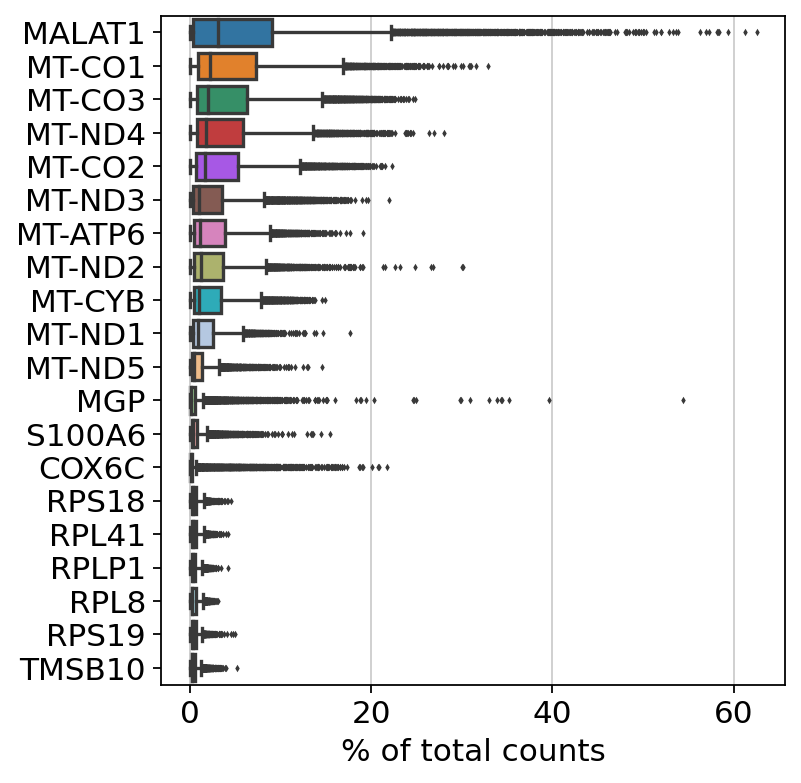

In [236]:
sc.pl.highest_expr_genes(adata_v, n_top=20)

In [237]:
adata_v = filter_minGenes_minCells(adata_v, 100, 3)

filtered out 1972 cells that have less than 100 genes expressed
filtered out 10920 genes that are detected in less than 3 cells


In [238]:
adata_v.shape

(19016, 21818)

In [239]:
adata_v = calc_percentMito_nCounts(adata_v)

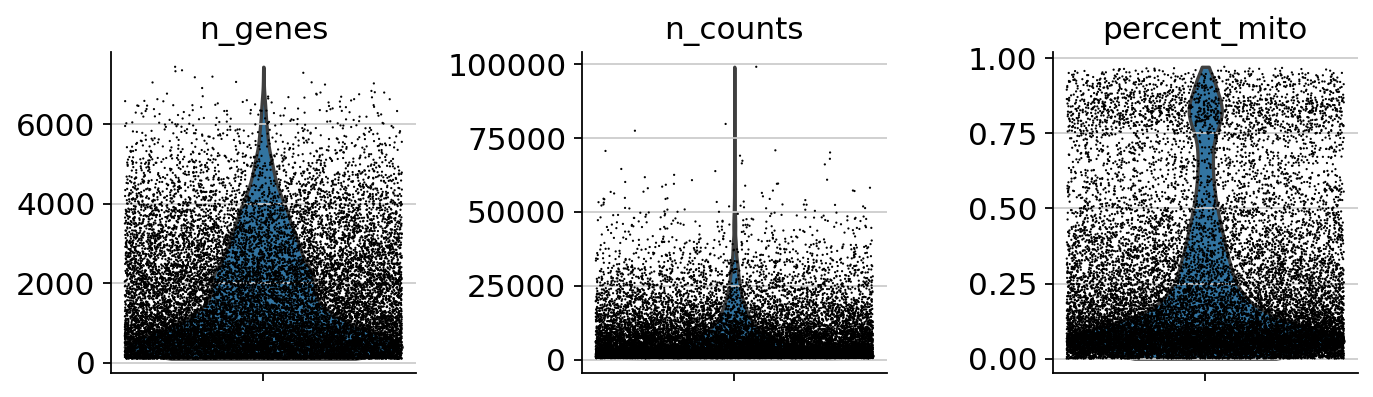

In [240]:
sc.pl.violin(adata_v, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

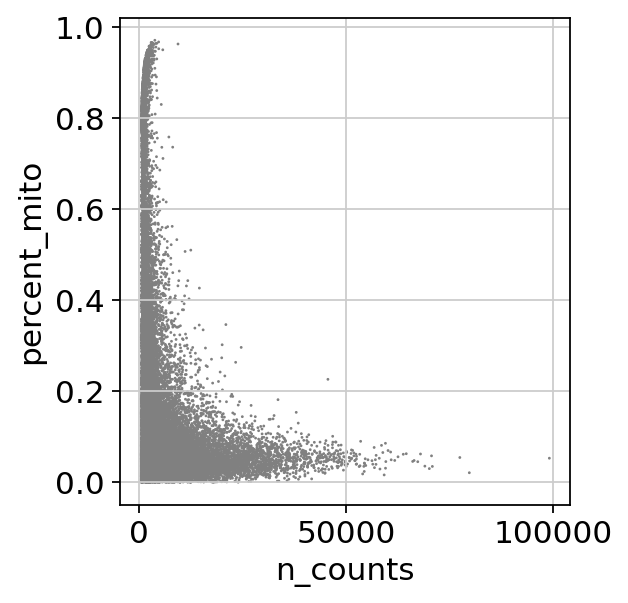

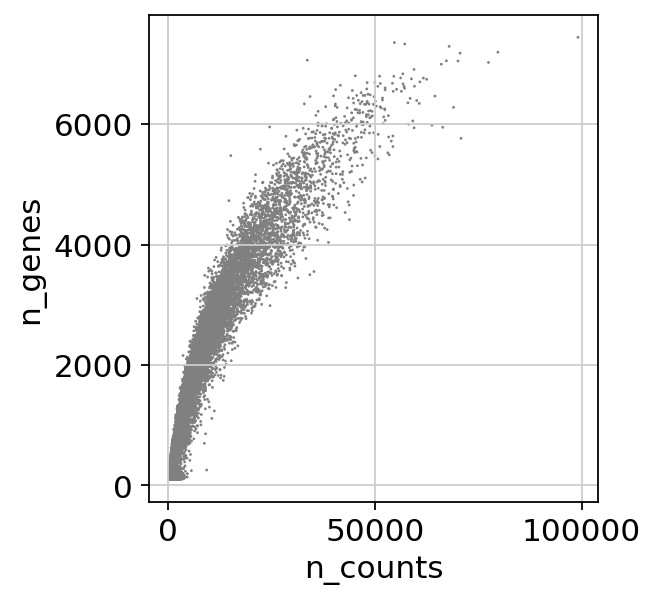

In [241]:
sc.pl.scatter(adata_v, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_v, x='n_counts', y='n_genes')

In [242]:
adata_v = filter_genes_mito(adata_v,100000,0.20)

In [243]:
adata_v.shape

(12136, 21818)

computing PCA with n_comps = 50
    finished (0:00:31)


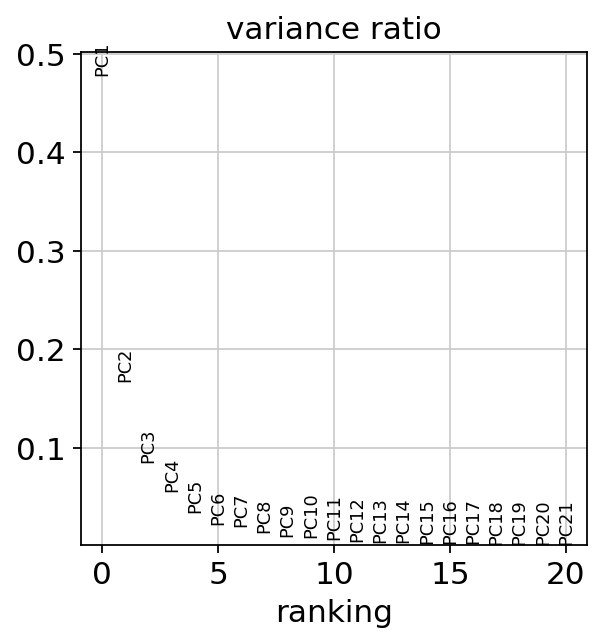

In [244]:
sc.tl.pca(adata_v, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_v, log=False,n_pcs = 20)

In [247]:
#sc.pl.pca(adata_v,color='pdx')

In [336]:
sc.pp.neighbors(adata_v, n_neighbors=10, knn = True, n_pcs=20)
#sc.tl.umap(adata_v)

computing neighbors
    using 'X_pca' with n_pcs = 20


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [281]:
#sc.tl.tsne(adata_v)

In [337]:
neighbor_array = adata_v.uns['neighbors']['distances'].toarray()

parental_percent = []
LM_percent = []
#for i in range(0,len(adata_v)):
for i in range(0,len(adata_v)):
    neighbors = adata_v.obs[neighbor_array[i]!=0].Tissue
    LM_p = np.sum(neighbors == 'lung')/9.0
    LM_percent.append(LM_p)
    parental_percent.append(1-LM_p)

In [338]:
adata_v.obs['LM_percent'] = np.array(LM_percent)
adata_v.obs['parental_percent'] = np.array(parental_percent)

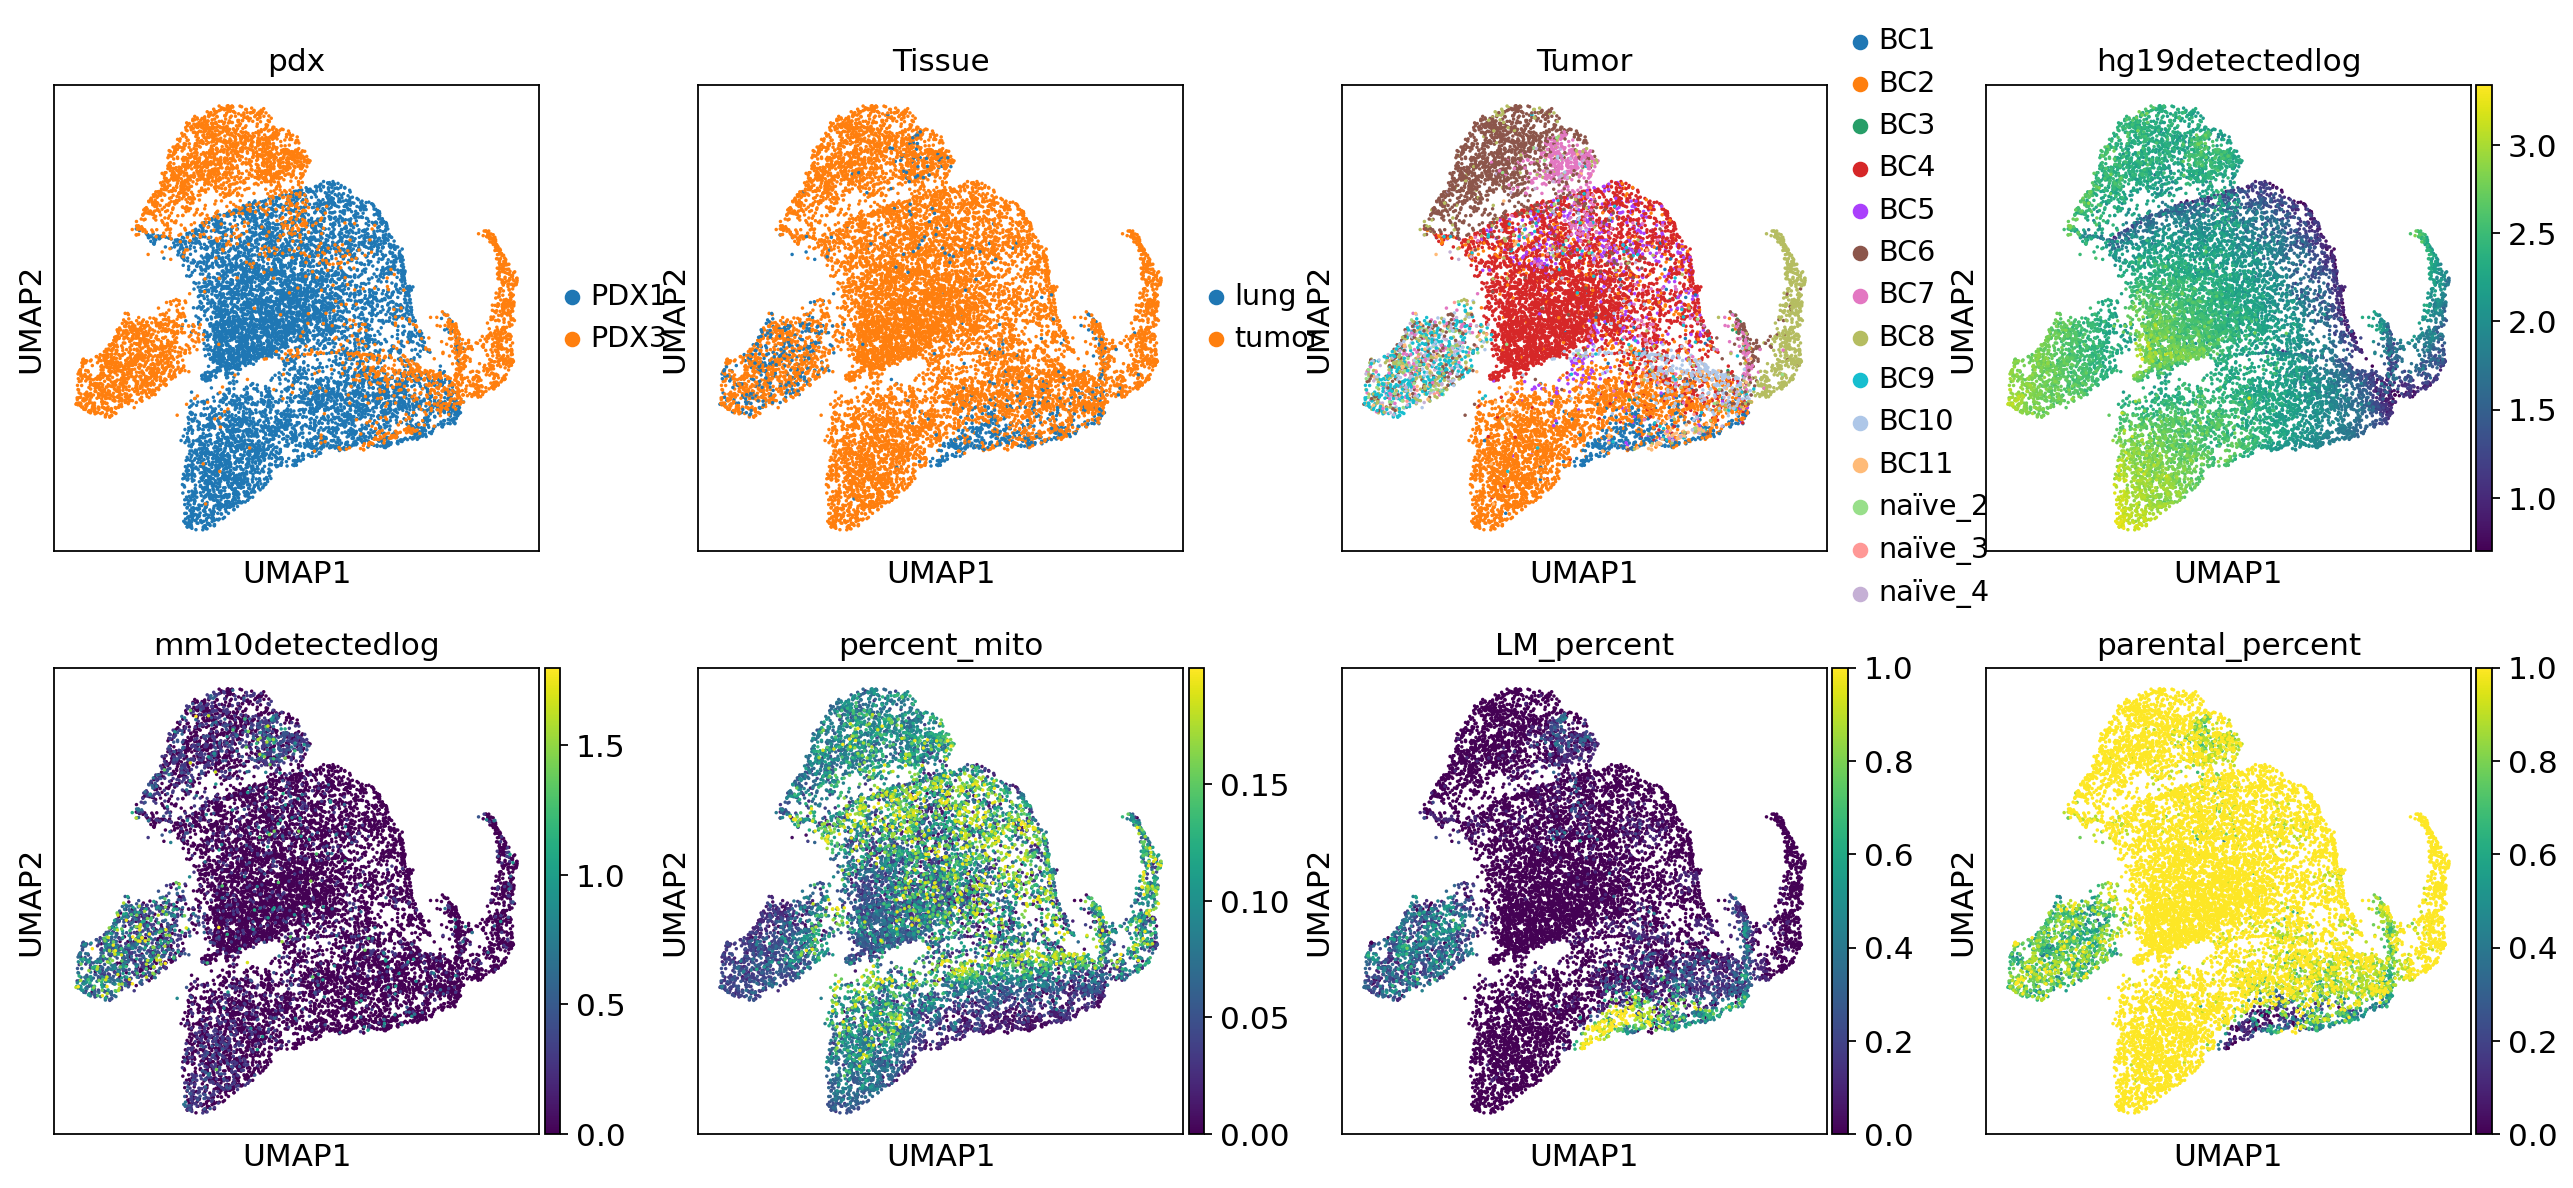

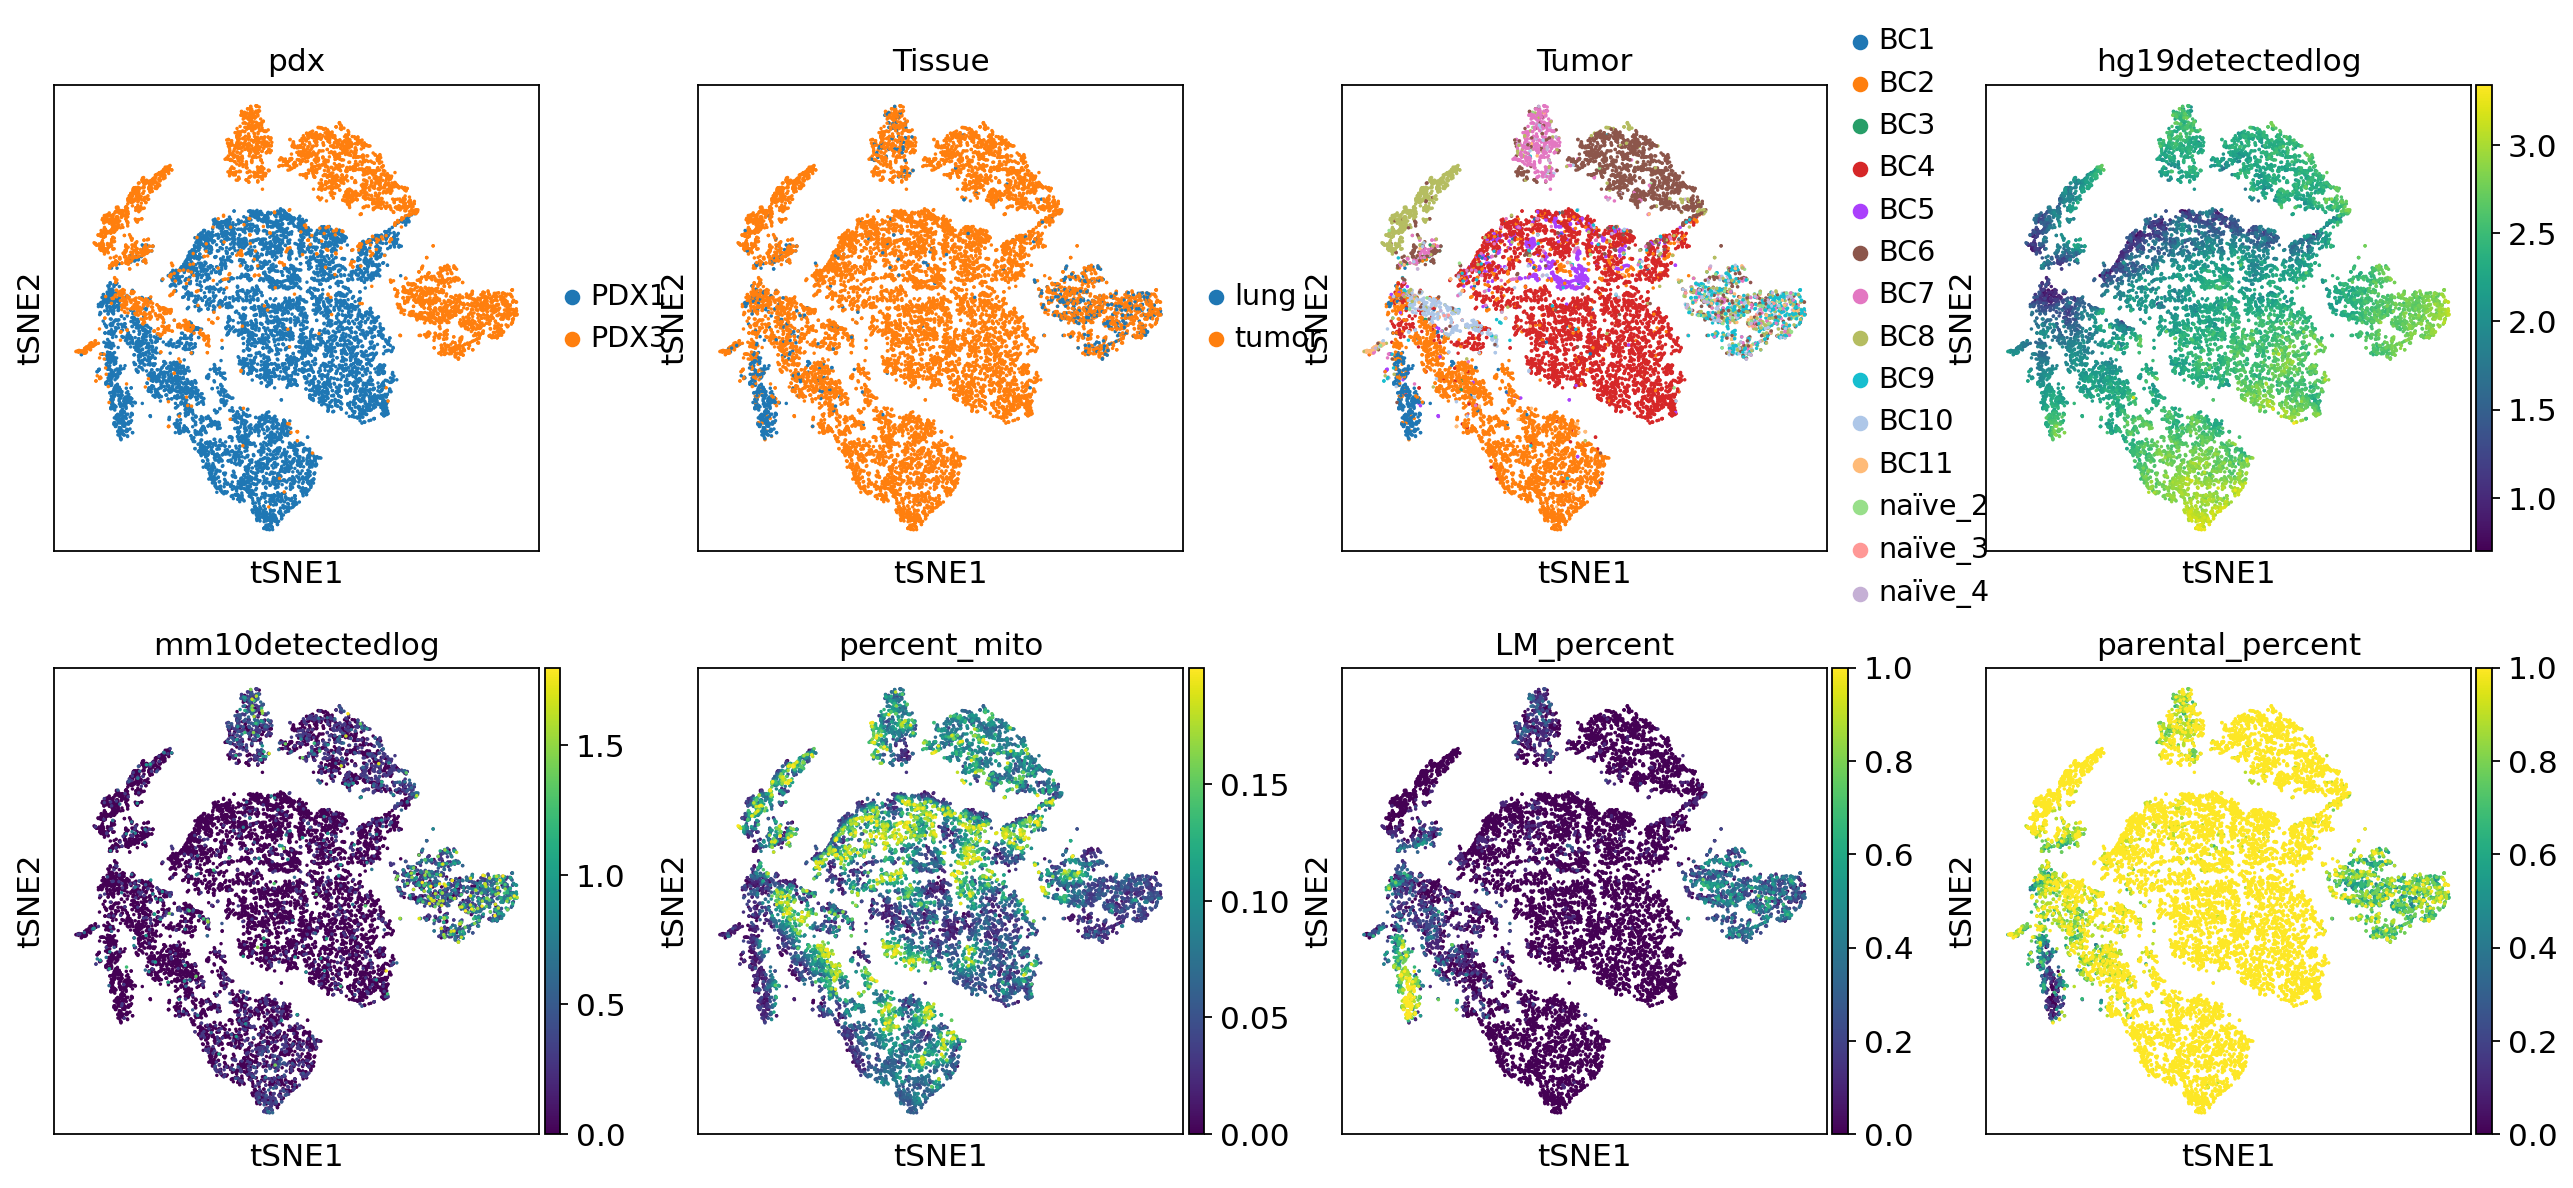

In [345]:
sc.pl.umap(adata_v,color=['pdx','Tissue','Tumor','hg19detectedlog','mm10detectedlog','percent_mito','LM_percent','parental_percent'])
sc.pl.tsne(adata_v,color=['pdx','Tissue','Tumor','hg19detectedlog','mm10detectedlog','percent_mito','LM_percent','parental_percent'])

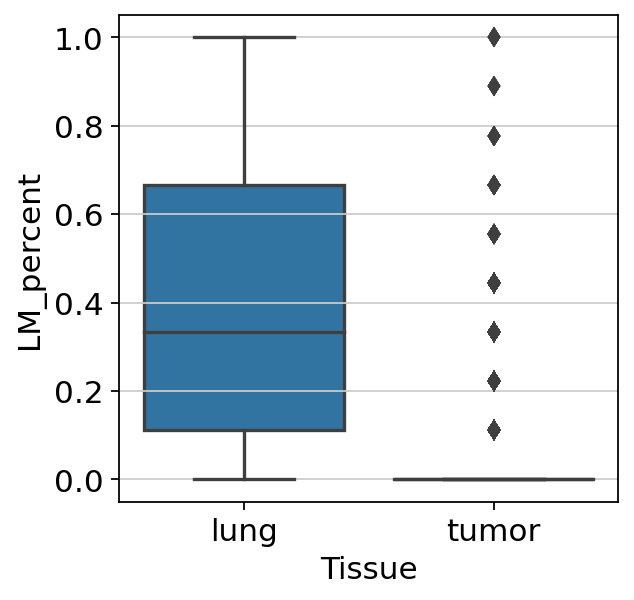

In [340]:
sns.boxplot(x='Tissue',y='LM_percent',data=adata_v.obs)

In [380]:
adata_v.obs['Subtype'] = ''

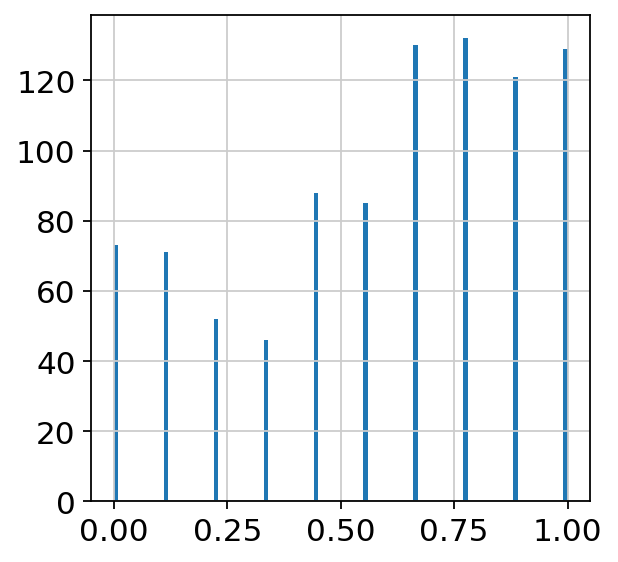

In [381]:
lung_LM2 = adata_v.obs.parental_percent[adata_v.obs.Tissue=='lung']
#plt.hist(lung_LM2[lung_LM2<0.5],bins=100,log=False)
plt.hist(lung_LM2,bins=100,log=False)
plt.show()

In [382]:
adata_v.obs['Subtype'][adata_v.obs.Tissue=='lung'] = np.where(adata_v.obs.parental_percent[adata_v.obs.Tissue=='lung'] <0.45,'LM-L','LM-H')


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([8.819e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.081e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.850e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.630e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.980e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.400e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.700e+01,
        0.000e+00, 0.000e+00, 0.000e+0

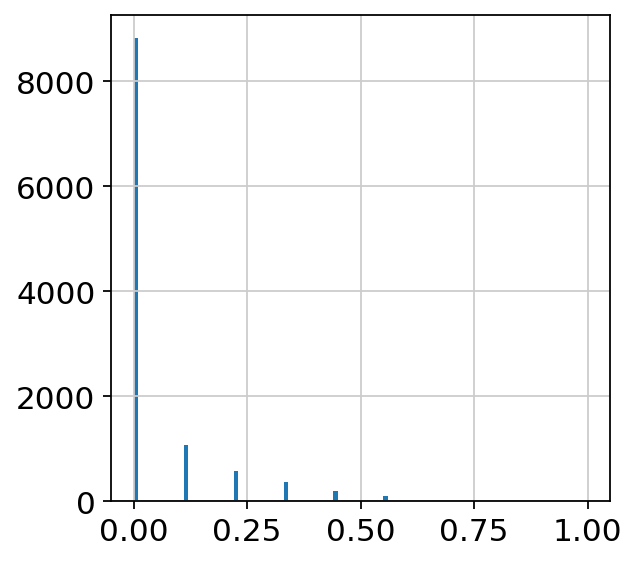

In [383]:
plt.hist(adata_v.obs.LM_percent[adata_v.obs.Tissue=='tumor'],bins=100,log=False)
#plt.show()

In [386]:
adata_v.obs['Subtype'][adata_v.obs.Tissue=='tumor'] = np.where(adata_v.obs.LM_percent[adata_v.obs.Tissue=='tumor'] <0.15,'p-L','p-H')



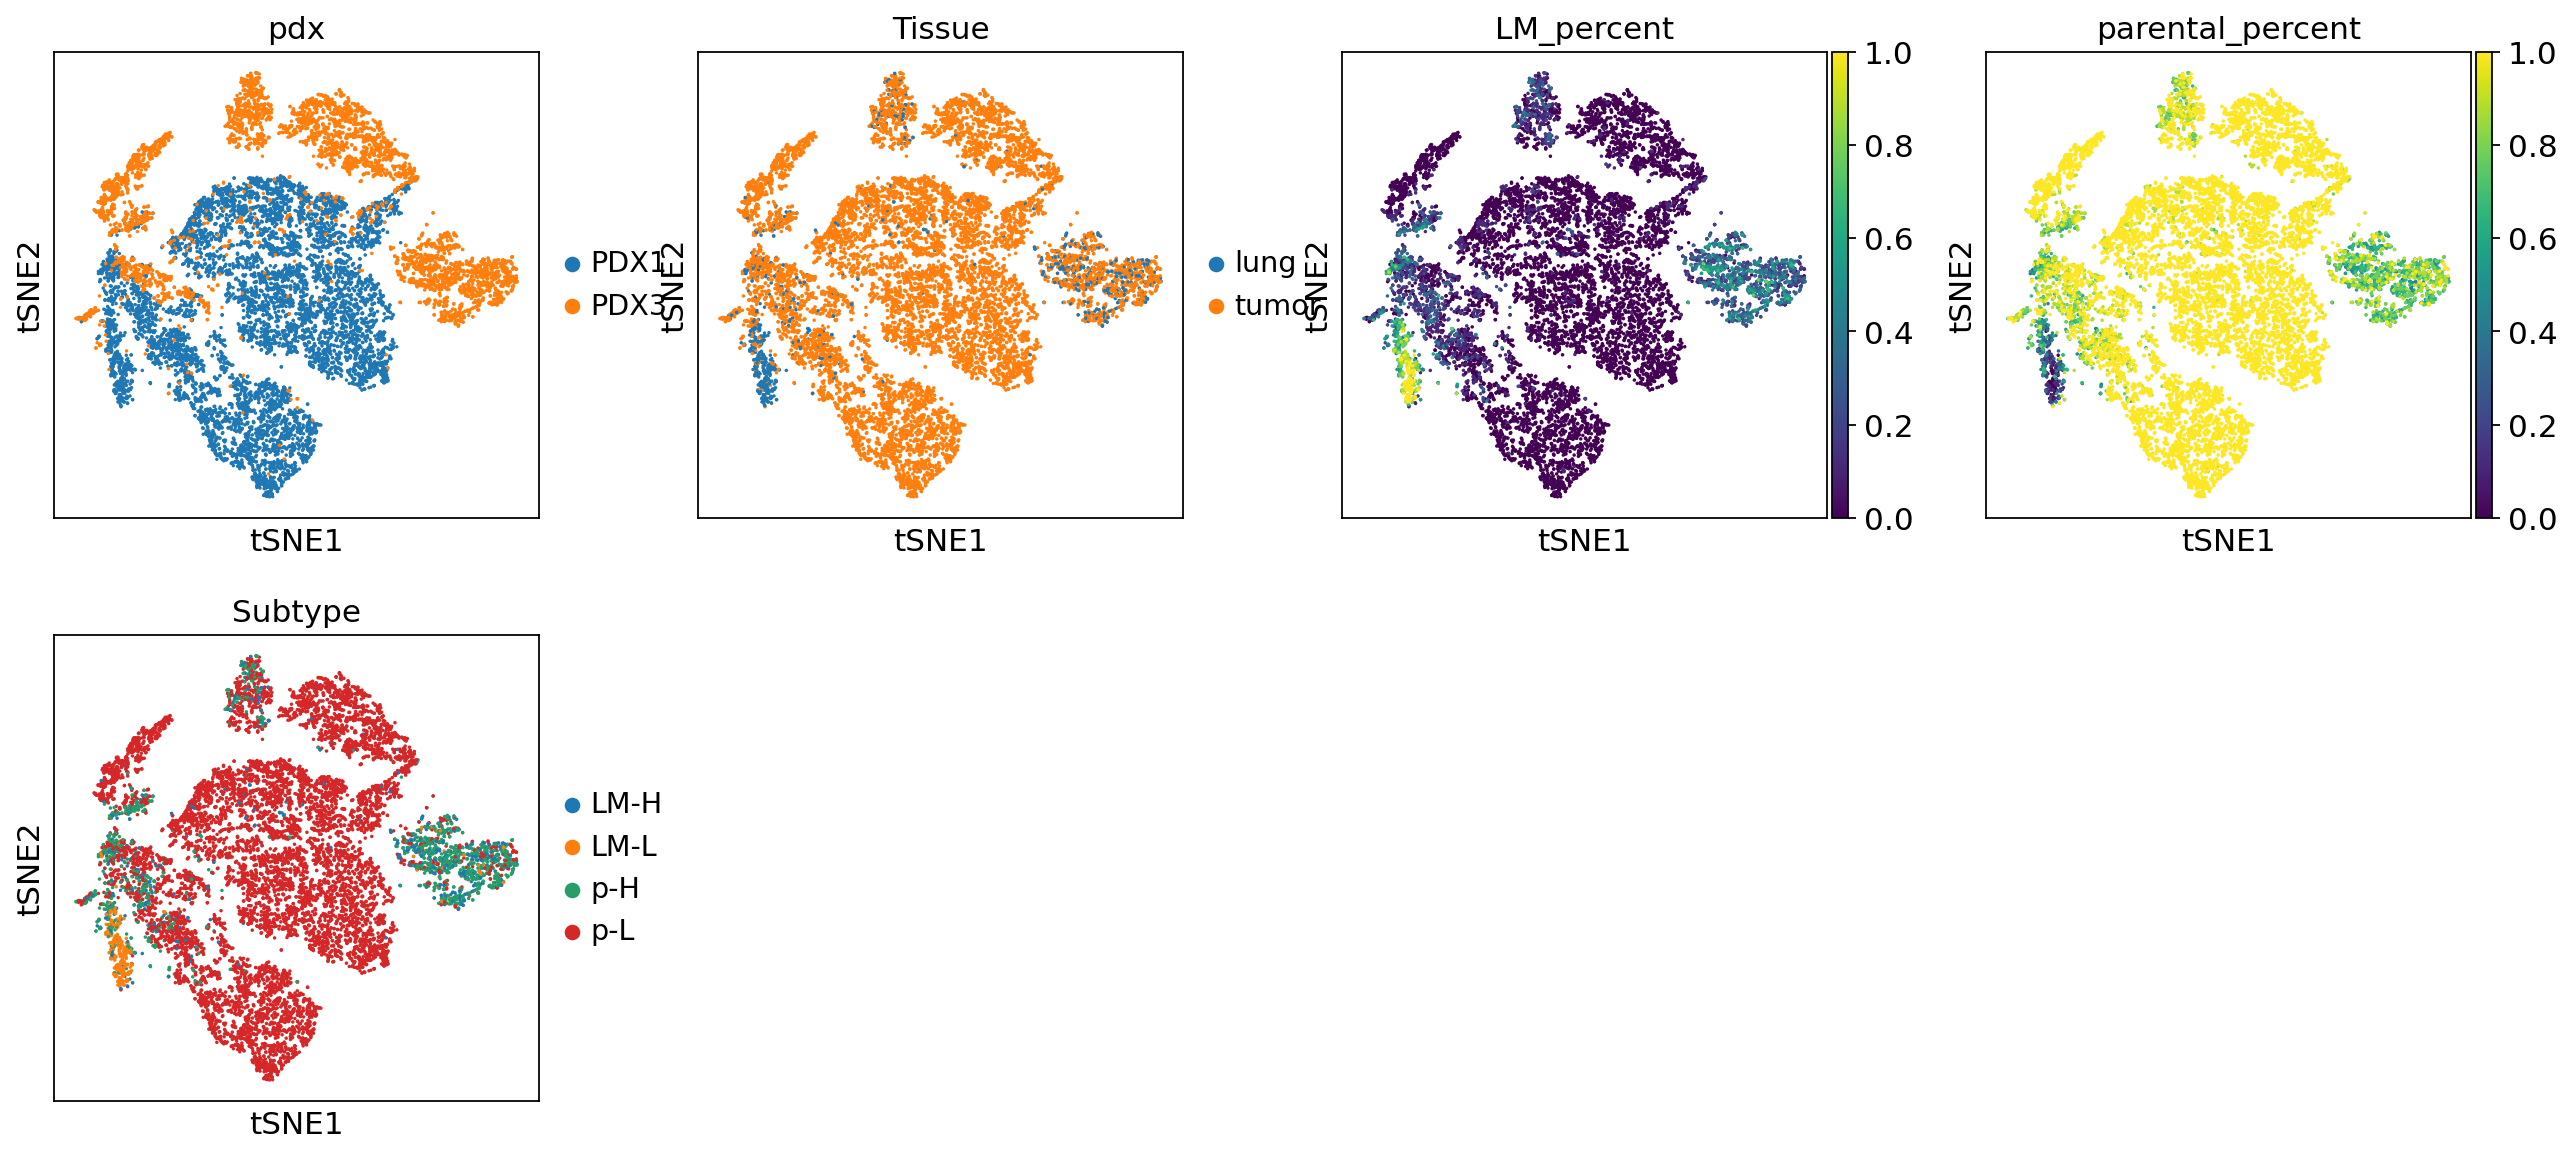

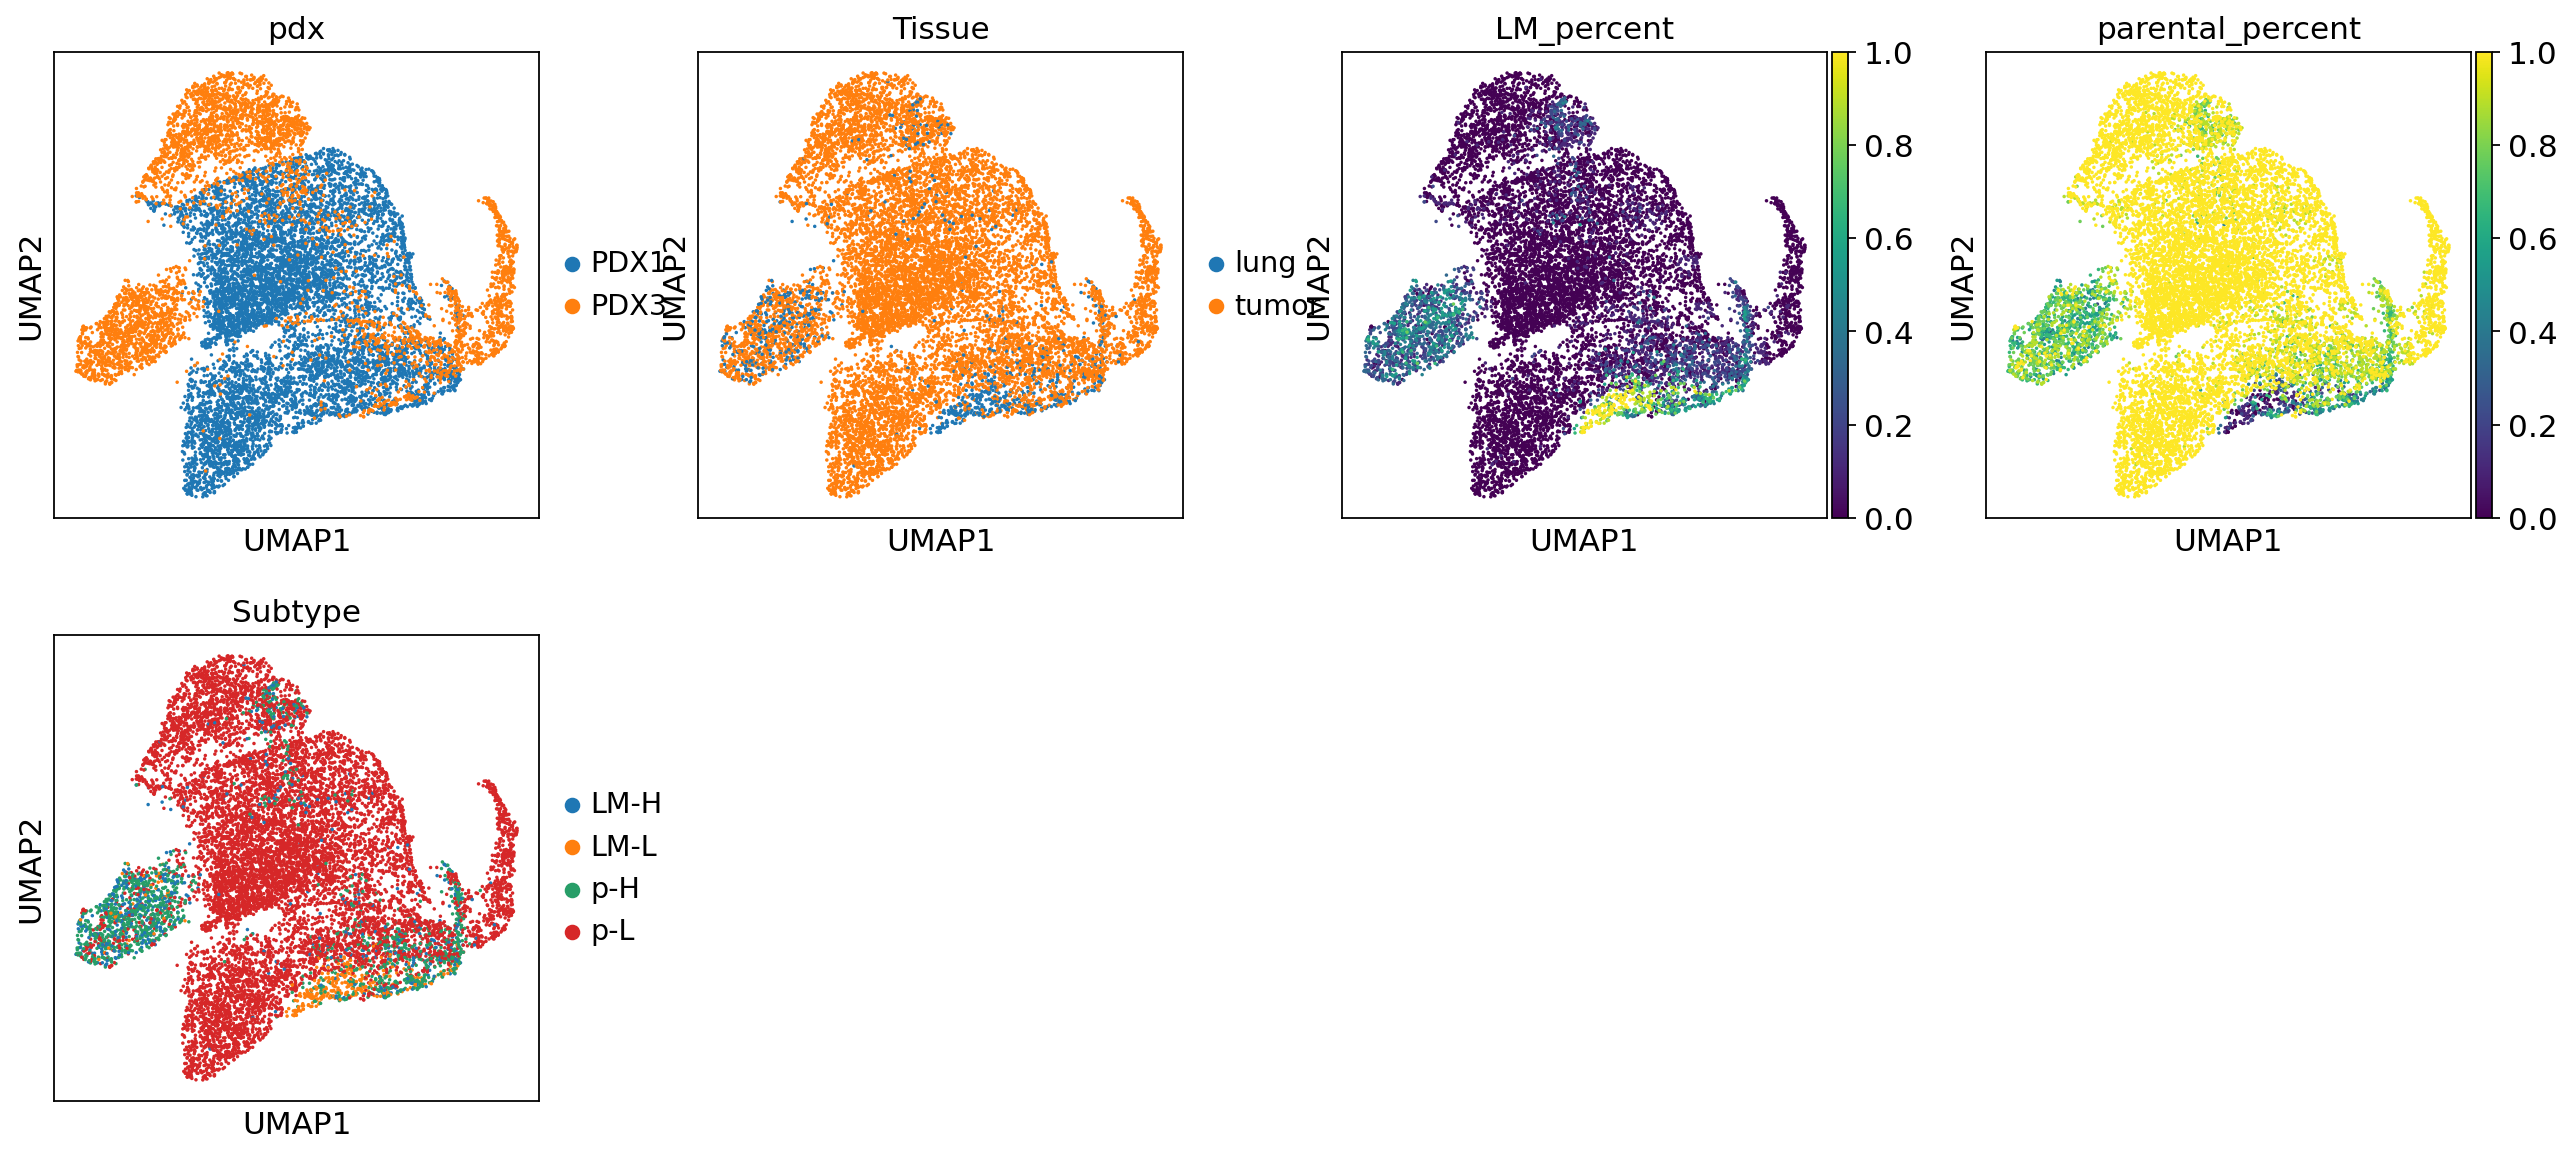

In [387]:
sc.pl.tsne(adata_v,color=['pdx','Tissue','LM_percent','parental_percent','Subtype'])
sc.pl.umap(adata_v,color=['pdx','Tissue','LM_percent','parental_percent','Subtype'])

## Write out datasets

In [388]:
## Save an unnormalized, QC'd version of the file
adata_v.write(outfilePath)
adata_v.write_csvs(outfilePath_R)
np.savetxt(outfilePath_csv,adata_v.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/PDX_adata_R


## Scale and normalize the dataset

In [389]:
## For vision, recommendation is size-factor normalization within ineach cell 
sc.pp.normalize_total(adata_v,target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [390]:
## Save an normalized, QC'd version of the file
adata_v.write(outfilePathNorm)
adata_v.write_csvs(outfilePathNorm_R)
np.savetxt(outfilePathNorm_csv,adata_v.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/PDX_normalized_adata_R
